In [ ]:
# !sudo apt install swig

In [ ]:
# !pip install quantstats
# !pip install scikit-learn
# !pip install torch
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [43]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch
import os
import numpy as np

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE, EI3, GPM
from torch_geometric.utils import k_hop_subgraph

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [61]:
TEST_SET = [
    "AAPL", "CVX", "GS", "JNJ",
    "JPM", "MSFT", "PFE", "PG",
    "UL", "XOM"
]
START_DATE = '2013-01-01'
END_DATE = '2023-12-31'
print(len(TEST_SET))

portfolio_raw_df = YahooDownloader(start_date = START_DATE,
                                end_date = END_DATE,
                                ticker_list = TEST_SET).fetch_data()
portfolio_raw_df
portfolio_raw_df.groupby("tic").count()
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(portfolio_raw_df)
portfolio_norm_df
df_portfolio = portfolio_norm_df[["date", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[(df_portfolio["date"] >= START_DATE) & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]
df_portfolio_2023 = df_portfolio[(df_portfolio["date"] >= "2023-01-01") & (df_portfolio["date"] < END_DATE)]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

10



[*********************100%***********************]  1 of 1 completed
/Users/ethan/Documents/GitHub/DSE4212/venv/lib/python3.10/site-packages/finrl/meta/preprocessor/preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.38369243 0.24161592 0.40684028 ... 0.03291756 0.02330824 0.02918077]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
/Users/ethan/Documents/GitHub/DSE4212/venv/lib/python3.10/site-packages/finrl/meta/preprocessor/preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5  0.75 1.   ... 0.5  0.75 1.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(


Shape of DataFrame:  (27680, 8)


In [73]:
TIME_WINDOW = 50
COMISSION_FEE = 0.0005
FEATURE_NAMES = ["close", "high", "low"]
environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=COMISSION_FEE,
        time_window=TIME_WINDOW,
        features=FEATURE_NAMES,
        normalize_df=None,
        reward_scaling=1.0,
    )

"""EIIE (ensemble of identical independent evaluators) policy network
initializer.
Args:
    initial_features: Number of input features.
    k_size: Size of first convolutional kernel.
    conv_mid_features: Size of intermediate convolutional channels.
    conv_final_features: Size of final convolutional channels.
    time_window: Size of time window used as agent's state.
    device: Device in which the neural network will be run.
Note:
    Reference article: https://doi.org/10.48550/arXiv.1706.10059.
"""
EIIE_model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}
EIIE_policy_kwargs = {
    "k_size": len(FEATURE_NAMES),
    "time_window": TIME_WINDOW,
}
EIIE_model = DRLAgent(environment).get_model("pg", device, EIIE_model_kwargs, EIIE_policy_kwargs)



# """EI3 (ensemble of identical independent inception) policy network
# initializer.
# Args:
#     initial_features: Number of input features.
#     k_short: Size of short convolutional kernel.
#     k_medium: Size of medium convolutional kernel.
#     conv_mid_features: Size of intermediate convolutional channels.
#     conv_final_features: Size of final convolutional channels.
#     time_window: Size of time window used as agent's state.
#     device: Device in which the neural network will be run.
# Note:
#     Reference article: https://doi.org/10.1145/3357384.3357961.
# """

# EI3_model_kwargs = {
#     "lr": 0.01,
#     "policy": EI3,
# }
# EI3_policy_kwargs = {
#     "k_short": 3,
#     "k_medium": 21,
#     "time_window": 50,
# }
# EI3_model = DRLAgent(environment).get_model("pg", device, EI3_model_kwargs, EI3_policy_kwargs)

In [72]:
DRLAgent.train_model(EIIE_model, episodes=30)
torch.save(EIIE_model.train_policy.state_dict(), "policy_EIIE.pt")

  0%|          | 0/30 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 249808.109375
Final accumulative portfolio value: 2.49808109375
Maximum DrawDown: -0.32554927009990275
Sharpe ratio: 0.7997182622355301


  3%|▎         | 1/30 [00:06<03:10,  6.57s/it]

Initial portfolio value:100000
Final portfolio value: 296529.4375
Final accumulative portfolio value: 2.965294375
Maximum DrawDown: -0.32965118217991296
Sharpe ratio: 0.891050346225005


  7%|▋         | 2/30 [00:13<03:13,  6.91s/it]

Initial portfolio value:100000
Final portfolio value: 592686.6875
Final accumulative portfolio value: 5.926866875
Maximum DrawDown: -0.33919526055240967
Sharpe ratio: 1.1247261433235236


 10%|█         | 3/30 [00:20<03:07,  6.95s/it]

Initial portfolio value:100000
Final portfolio value: 797676.9375
Final accumulative portfolio value: 7.976769375
Maximum DrawDown: -0.32015599006193696
Sharpe ratio: 1.1972178801418323


 13%|█▎        | 4/30 [00:27<03:00,  6.93s/it]

Initial portfolio value:100000
Final portfolio value: 861079.375
Final accumulative portfolio value: 8.61079375
Maximum DrawDown: -0.3138163298733778
Sharpe ratio: 1.198884907855333


 17%|█▋        | 5/30 [00:34<02:51,  6.85s/it]

Initial portfolio value:100000
Final portfolio value: 873776.375
Final accumulative portfolio value: 8.73776375
Maximum DrawDown: -0.31247146966436945
Sharpe ratio: 1.2037496759077952


 20%|██        | 6/30 [00:41<02:44,  6.84s/it]

Initial portfolio value:100000
Final portfolio value: 880720.3125
Final accumulative portfolio value: 8.807203125
Maximum DrawDown: -0.311718631966976
Sharpe ratio: 1.2076343057853445


 23%|██▎       | 7/30 [00:48<02:40,  6.99s/it]

Initial portfolio value:100000
Final portfolio value: 888751.5625
Final accumulative portfolio value: 8.887515625
Maximum DrawDown: -0.3109641278238595
Sharpe ratio: 1.2125437364295697


 27%|██▋       | 8/30 [00:55<02:32,  6.92s/it]

Initial portfolio value:100000
Final portfolio value: 901190.0
Final accumulative portfolio value: 9.0119
Maximum DrawDown: -0.31089166083476905
Sharpe ratio: 1.2255139849167533


 30%|███       | 9/30 [01:02<02:25,  6.92s/it]

Initial portfolio value:100000
Final portfolio value: 906425.75
Final accumulative portfolio value: 9.0642575
Maximum DrawDown: -0.30997050459879993
Sharpe ratio: 1.2320811545490853


 33%|███▎      | 10/30 [01:08<02:17,  6.89s/it]

Initial portfolio value:100000
Final portfolio value: 915725.5625
Final accumulative portfolio value: 9.157255625
Maximum DrawDown: -0.30988871029202525
Sharpe ratio: 1.2343619379339918


 37%|███▋      | 11/30 [01:15<02:10,  6.87s/it]

Initial portfolio value:100000
Final portfolio value: 929184.375
Final accumulative portfolio value: 9.29184375
Maximum DrawDown: -0.30955377981931054
Sharpe ratio: 1.2405318261494895


 40%|████      | 12/30 [01:22<02:03,  6.84s/it]

Initial portfolio value:100000
Final portfolio value: 947349.0
Final accumulative portfolio value: 9.47349
Maximum DrawDown: -0.3091418322322954
Sharpe ratio: 1.2499439350235957


 43%|████▎     | 13/30 [01:29<01:57,  6.92s/it]

Initial portfolio value:100000
Final portfolio value: 969735.125
Final accumulative portfolio value: 9.69735125
Maximum DrawDown: -0.3090623286884192
Sharpe ratio: 1.262600652698554


 47%|████▋     | 14/30 [01:36<01:48,  6.80s/it]

Initial portfolio value:100000
Final portfolio value: 995921.8125
Final accumulative portfolio value: 9.959218125
Maximum DrawDown: -0.30879093354899845
Sharpe ratio: 1.2813266825152427


 50%|█████     | 15/30 [01:43<01:44,  6.94s/it]

Initial portfolio value:100000
Final portfolio value: 1013415.1875
Final accumulative portfolio value: 10.134151875
Maximum DrawDown: -0.3078688899492168
Sharpe ratio: 1.2868198673995552


 53%|█████▎    | 16/30 [01:50<01:37,  7.00s/it]

Initial portfolio value:100000
Final portfolio value: 1054337.875
Final accumulative portfolio value: 10.54337875
Maximum DrawDown: -0.30863620296840133
Sharpe ratio: 1.305495331571313


 57%|█████▋    | 17/30 [01:57<01:32,  7.08s/it]

Initial portfolio value:100000
Final portfolio value: 1092432.625
Final accumulative portfolio value: 10.92432625
Maximum DrawDown: -0.31146895267732855
Sharpe ratio: 1.32038248492231


 60%|██████    | 18/30 [02:04<01:23,  6.98s/it]

Initial portfolio value:100000
Final portfolio value: 1146749.25
Final accumulative portfolio value: 11.4674925
Maximum DrawDown: -0.31523387944577663
Sharpe ratio: 1.340382160874337


 63%|██████▎   | 19/30 [02:11<01:17,  7.05s/it]

Initial portfolio value:100000
Final portfolio value: 1191986.625
Final accumulative portfolio value: 11.91986625
Maximum DrawDown: -0.318214379514963
Sharpe ratio: 1.3573663534533391


 67%|██████▋   | 20/30 [02:18<01:10,  7.03s/it]

Initial portfolio value:100000
Final portfolio value: 1252874.875
Final accumulative portfolio value: 12.52874875
Maximum DrawDown: -0.30591302086596606
Sharpe ratio: 1.3904629791646503


 70%|███████   | 21/30 [02:25<01:03,  7.05s/it]

Initial portfolio value:100000
Final portfolio value: 1281703.0
Final accumulative portfolio value: 12.81703
Maximum DrawDown: -0.3206899693103267
Sharpe ratio: 1.3817581928192628


 73%|███████▎  | 22/30 [02:33<00:58,  7.28s/it]

Initial portfolio value:100000
Final portfolio value: 1371593.75
Final accumulative portfolio value: 13.7159375
Maximum DrawDown: -0.32071584258188734
Sharpe ratio: 1.4091652946978857


 77%|███████▋  | 23/30 [02:41<00:51,  7.35s/it]

Initial portfolio value:100000
Final portfolio value: 1433027.75
Final accumulative portfolio value: 14.3302775
Maximum DrawDown: -0.3152665999370192
Sharpe ratio: 1.4264428054207425


 80%|████████  | 24/30 [02:48<00:43,  7.23s/it]

Initial portfolio value:100000
Final portfolio value: 1461946.25
Final accumulative portfolio value: 14.6194625
Maximum DrawDown: -0.3198508261776214
Sharpe ratio: 1.435566209057589


 83%|████████▎ | 25/30 [02:55<00:36,  7.24s/it]

Initial portfolio value:100000
Final portfolio value: 1555408.125
Final accumulative portfolio value: 15.55408125
Maximum DrawDown: -0.314734318380434
Sharpe ratio: 1.4597884208487266


 87%|████████▋ | 26/30 [03:02<00:28,  7.09s/it]

Initial portfolio value:100000
Final portfolio value: 1559875.875
Final accumulative portfolio value: 15.59875875
Maximum DrawDown: -0.3226607402048297
Sharpe ratio: 1.4486679228872357


 90%|█████████ | 27/30 [03:09<00:21,  7.09s/it]

Initial portfolio value:100000
Final portfolio value: 1635462.25
Final accumulative portfolio value: 16.3546225
Maximum DrawDown: -0.31793181039292717
Sharpe ratio: 1.4665002728023526


 93%|█████████▎| 28/30 [03:16<00:14,  7.01s/it]

Initial portfolio value:100000
Final portfolio value: 1560292.375
Final accumulative portfolio value: 15.60292375
Maximum DrawDown: -0.3327737821465847
Sharpe ratio: 1.4444123799699404


 97%|█████████▋| 29/30 [03:22<00:06,  6.90s/it]

Initial portfolio value:100000
Final portfolio value: 1659013.625
Final accumulative portfolio value: 16.59013625
Maximum DrawDown: -0.3316003578186014
Sharpe ratio: 1.4633246803129802


100%|██████████| 30/30 [03:29<00:00,  6.98s/it]


In [12]:
# environment.reset()
# DRLAgent.train_model(EI3_model, episodes=40)
# torch.save(EI3_model.train_policy.state_dict(), "policy_EI3.pt")

  0%|          | 0/40 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 315260.9375
Final accumulative portfolio value: 3.152609375
Maximum DrawDown: -0.3445222140195028
Sharpe ratio: 0.907166881746057


  2%|▎         | 1/40 [00:06<04:26,  6.83s/it]

Initial portfolio value:100000
Final portfolio value: 713771.25
Final accumulative portfolio value: 7.1377125
Maximum DrawDown: -0.2762503224487268
Sharpe ratio: 1.2982818563143357


  5%|▌         | 2/40 [00:13<04:13,  6.67s/it]

Initial portfolio value:100000
Final portfolio value: 842076.75
Final accumulative portfolio value: 8.4207675
Maximum DrawDown: -0.32888935890358106
Sharpe ratio: 1.2082658662859247


  8%|▊         | 3/40 [00:19<04:03,  6.59s/it]

Initial portfolio value:100000
Final portfolio value: 839858.875
Final accumulative portfolio value: 8.39858875
Maximum DrawDown: -0.3144655129309676
Sharpe ratio: 1.186393013322557


 10%|█         | 4/40 [00:26<03:54,  6.53s/it]

Initial portfolio value:100000
Final portfolio value: 868874.375
Final accumulative portfolio value: 8.68874375
Maximum DrawDown: -0.31291655798324636
Sharpe ratio: 1.2005147095124347


 12%|█▎        | 5/40 [00:32<03:46,  6.48s/it]

Initial portfolio value:100000
Final portfolio value: 887945.0625
Final accumulative portfolio value: 8.879450625
Maximum DrawDown: -0.31251781730292516
Sharpe ratio: 1.2152785107485244


 15%|█▌        | 6/40 [00:39<03:44,  6.60s/it]

Initial portfolio value:100000
Final portfolio value: 906490.125
Final accumulative portfolio value: 9.06490125
Maximum DrawDown: -0.312271861315671
Sharpe ratio: 1.2296130970786263


 18%|█▊        | 7/40 [00:45<03:36,  6.55s/it]

Initial portfolio value:100000
Final portfolio value: 926961.8125
Final accumulative portfolio value: 9.269618125
Maximum DrawDown: -0.31155746250733163
Sharpe ratio: 1.2448156638840862


 20%|██        | 8/40 [00:52<03:28,  6.52s/it]

Initial portfolio value:100000
Final portfolio value: 952406.25
Final accumulative portfolio value: 9.5240625
Maximum DrawDown: -0.3107366596411054
Sharpe ratio: 1.262231397189525


 22%|██▎       | 9/40 [00:59<03:22,  6.55s/it]

Initial portfolio value:100000
Final portfolio value: 984820.25
Final accumulative portfolio value: 9.8482025
Maximum DrawDown: -0.309930253599527
Sharpe ratio: 1.2824840334824146


 25%|██▌       | 10/40 [01:05<03:15,  6.52s/it]

Initial portfolio value:100000
Final portfolio value: 1025918.1875
Final accumulative portfolio value: 10.259181875
Maximum DrawDown: -0.30929396659326935
Sharpe ratio: 1.3058548666980598


 28%|██▊       | 11/40 [01:11<03:08,  6.49s/it]

Initial portfolio value:100000
Final portfolio value: 1076495.0
Final accumulative portfolio value: 10.76495
Maximum DrawDown: -0.31174194542119915
Sharpe ratio: 1.331276371592175


 30%|███       | 12/40 [01:18<03:01,  6.47s/it]

Initial portfolio value:100000
Final portfolio value: 1135299.625
Final accumulative portfolio value: 11.35299625
Maximum DrawDown: -0.3169793939275729
Sharpe ratio: 1.3565194279690944


 32%|███▎      | 13/40 [01:24<02:54,  6.46s/it]

Initial portfolio value:100000
Final portfolio value: 1197045.25
Final accumulative portfolio value: 11.9704525
Maximum DrawDown: -0.32415418886835856
Sharpe ratio: 1.3782597357925581


 35%|███▌      | 14/40 [01:31<02:47,  6.45s/it]

Initial portfolio value:100000
Final portfolio value: 1254932.0
Final accumulative portfolio value: 12.54932
Maximum DrawDown: -0.3320834738697567
Sharpe ratio: 1.3947687923757328


 38%|███▊      | 15/40 [01:37<02:42,  6.48s/it]

Initial portfolio value:100000
Final portfolio value: 1303985.625
Final accumulative portfolio value: 13.03985625
Maximum DrawDown: -0.3402358021337347
Sharpe ratio: 1.4043954946652977


 40%|████      | 16/40 [01:44<02:35,  6.46s/it]

Initial portfolio value:100000
Final portfolio value: 1346276.375
Final accumulative portfolio value: 13.46276375
Maximum DrawDown: -0.345755656095489
Sharpe ratio: 1.4137891210654807


 42%|████▎     | 17/40 [01:50<02:28,  6.45s/it]

Initial portfolio value:100000
Final portfolio value: 1338327.875
Final accumulative portfolio value: 13.38327875
Maximum DrawDown: -0.3568603732901846
Sharpe ratio: 1.388366765142858


 45%|████▌     | 18/40 [01:57<02:21,  6.45s/it]

Initial portfolio value:100000
Final portfolio value: 250885.09375
Final accumulative portfolio value: 2.5088509375
Maximum DrawDown: -0.3200528815333562
Sharpe ratio: 0.6684743235127842


 48%|████▊     | 19/40 [02:03<02:15,  6.44s/it]

Initial portfolio value:100000
Final portfolio value: 188766.65625
Final accumulative portfolio value: 1.8876665625
Maximum DrawDown: -0.3012599439449547
Sharpe ratio: 0.49929107093500663


 50%|█████     | 20/40 [02:09<02:08,  6.44s/it]

Initial portfolio value:100000
Final portfolio value: 188949.4375
Final accumulative portfolio value: 1.889494375
Maximum DrawDown: -0.30125981865175033
Sharpe ratio: 0.49967202814910877


 52%|█████▎    | 21/40 [02:16<02:02,  6.43s/it]

Initial portfolio value:100000
Final portfolio value: 188971.15625
Final accumulative portfolio value: 1.8897115625
Maximum DrawDown: -0.30125984450527044
Sharpe ratio: 0.4997110438126139


 55%|█████▌    | 22/40 [02:22<01:55,  6.43s/it]

Initial portfolio value:100000
Final portfolio value: 188981.6875
Final accumulative portfolio value: 1.889816875
Maximum DrawDown: -0.3012597022254575
Sharpe ratio: 0.49972961518889164


 57%|█████▊    | 23/40 [02:29<01:49,  6.43s/it]

Initial portfolio value:100000
Final portfolio value: 188989.40625
Final accumulative portfolio value: 1.8898940625
Maximum DrawDown: -0.30125997458666975
Sharpe ratio: 0.49974142854609804


 60%|██████    | 24/40 [02:35<01:42,  6.43s/it]

Initial portfolio value:100000
Final portfolio value: 188996.015625
Final accumulative portfolio value: 1.88996015625
Maximum DrawDown: -0.30125993182127286
Sharpe ratio: 0.4997546515841505


 62%|██████▎   | 25/40 [02:42<01:36,  6.47s/it]

Initial portfolio value:100000
Final portfolio value: 189001.921875
Final accumulative portfolio value: 1.89001921875
Maximum DrawDown: -0.30125963514824505
Sharpe ratio: 0.49976578246479125


 65%|██████▌   | 26/40 [02:48<01:30,  6.45s/it]

Initial portfolio value:100000
Final portfolio value: 189006.796875
Final accumulative portfolio value: 1.89006796875
Maximum DrawDown: -0.30125995691133056
Sharpe ratio: 0.49977276914069135


 68%|██████▊   | 27/40 [02:55<01:23,  6.45s/it]

Initial portfolio value:100000
Final portfolio value: 189010.625
Final accumulative portfolio value: 1.89010625
Maximum DrawDown: -0.3012603997300731
Sharpe ratio: 0.49977740479293825


 70%|███████   | 28/40 [03:01<01:17,  6.44s/it]

Initial portfolio value:100000
Final portfolio value: 189015.09375
Final accumulative portfolio value: 1.8901509375
Maximum DrawDown: -0.30125971598049306
Sharpe ratio: 0.49978633072753464


 72%|███████▎  | 29/40 [03:07<01:10,  6.44s/it]

Initial portfolio value:100000
Final portfolio value: 189019.921875
Final accumulative portfolio value: 1.89019921875
Maximum DrawDown: -0.3012590809479133
Sharpe ratio: 0.49979388355620985


 75%|███████▌  | 30/40 [03:14<01:04,  6.43s/it]

Initial portfolio value:100000
Final portfolio value: 189023.25
Final accumulative portfolio value: 1.8902325
Maximum DrawDown: -0.3012590984581607
Sharpe ratio: 0.4997986463526372


 78%|███████▊  | 31/40 [03:20<00:57,  6.42s/it]

Initial portfolio value:100000
Final portfolio value: 189025.484375
Final accumulative portfolio value: 1.89025484375
Maximum DrawDown: -0.3012592779331843
Sharpe ratio: 0.4998000694912254


 80%|████████  | 32/40 [03:27<00:51,  6.42s/it]

Initial portfolio value:100000
Final portfolio value: 189028.296875
Final accumulative portfolio value: 1.89028296875
Maximum DrawDown: -0.30125945231592044
Sharpe ratio: 0.49980560829925064


 82%|████████▎ | 33/40 [03:33<00:44,  6.41s/it]

Initial portfolio value:100000
Final portfolio value: 189029.6875
Final accumulative portfolio value: 1.890296875
Maximum DrawDown: -0.3012593302425095
Sharpe ratio: 0.49980699844150256


 85%|████████▌ | 34/40 [03:39<00:38,  6.42s/it]

Initial portfolio value:100000
Final portfolio value: 189032.40625
Final accumulative portfolio value: 1.8903240625
Maximum DrawDown: -0.3012596594589515
Sharpe ratio: 0.49981245413923636


 88%|████████▊ | 35/40 [03:46<00:32,  6.42s/it]

Initial portfolio value:100000
Final portfolio value: 189033.453125
Final accumulative portfolio value: 1.89033453125
Maximum DrawDown: -0.30125939439411087
Sharpe ratio: 0.4998120965167633


 90%|█████████ | 36/40 [03:52<00:25,  6.42s/it]

Initial portfolio value:100000
Final portfolio value: 189035.140625
Final accumulative portfolio value: 1.89035140625
Maximum DrawDown: -0.3012587865274283
Sharpe ratio: 0.4998123994114851


 92%|█████████▎| 37/40 [03:59<00:19,  6.42s/it]

Initial portfolio value:100000
Final portfolio value: 189037.171875
Final accumulative portfolio value: 1.89037171875
Maximum DrawDown: -0.3012593223098362
Sharpe ratio: 0.4998150044141911


 95%|█████████▌| 38/40 [04:05<00:12,  6.46s/it]

Initial portfolio value:100000
Final portfolio value: 189036.984375
Final accumulative portfolio value: 1.89036984375
Maximum DrawDown: -0.30125987806974797
Sharpe ratio: 0.49981402294026667


 98%|█████████▊| 39/40 [04:12<00:06,  6.46s/it]

Initial portfolio value:100000
Final portfolio value: 189039.09375
Final accumulative portfolio value: 1.8903909375
Maximum DrawDown: -0.30125933342296174
Sharpe ratio: 0.49981587817945405


100%|██████████| 40/40 [04:18<00:00,  6.47s/it]


GPM

In [ ]:

"""GPM (Graph-based Portfolio Management) policy network initializer.
Args:
    edge_index: Graph connectivity in COO format.
    edge_type: Type of each edge in edge_index.
    nodes_to_select: ID of nodes to be selected to the portfolio.
    initial_features: Number of input features.
    k_short: Size of short convolutional kernel.
    k_medium: Size of medium convolutional kernel.
    conv_mid_features: Size of intermediate convolutional channels.
    conv_final_features: Size of final convolutional channels.
    graph_layers: Number of graph neural network layers.
    time_window: Size of time window used as agent's state.
    softmax_temperature: Temperature parameter to softmax function.
    device: Device in which the neural network will be run.
Note:
    Reference articles:
    Si Shi, Jianjun Li, Guohui Li, Peng Pan, Qi Chen & Qing Sun. (2022). GPM: A graph convolutional network based reinforcement learning framework for portfolio management. https://doi.org/10.1016/j.neucom.2022.04.105.
    GPM Demo: https://cocalc.com/github/AI4Finance-Foundation/FinRL/blob/master/examples/FinRL_GPM_Demo.ipynb
    Temporal Relational Ranking: https://arxiv.org/pdf/1809.09441
    temporal relational ranking data: https://github.com/CaioSBC/Temporal_Relational_Stock_Ranking_FinRL 

"""
# GPM_model_kwargs = {
#     "lr": 0.01,
#     "policy": GPM,
# }
# GPM_policy_kwargs = {
#     "edge_index": ,
#     "edge_type": ,
#     "nodes_to_select": ,
# }
# GPM_model = DRLAgent(environment).get_model("pg", device, GPM_model_kwargs, GPM_policy_kwargs)
# DRLAgent.train_model(GPM_model, episodes=40)
# torch.save(GPM_model.train_policy.state_dict(), "policy_GPM.pt")

Evaluation

In [74]:
import os
import shutil

environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None
)

environment_2023 = PortfolioOptimizationEnv(
    df_portfolio_2023,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None
)

EIIE_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {}
}
# EI3_results = {
#     "train": {},
#     "2021": {},
#     "2022": {},
#     "2023": {}
# }

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
EIIE_policy = EIIE(time_window=TIME_WINDOW, device=device)
EIIE_policy.load_state_dict(torch.load("policy_EIIE.pt"))

environment.reset()
src_folder = "results/rl"
dst_folder = "results/train"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["train"]["value"] = environment._asset_memory["final"]
EIIE_results["train"]["actions"] = environment._actions_memory

src_folder = "results/rl"
dst_folder = "results/2021"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_2021, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]
EIIE_results["2021"]["actions"] = environment_2021._actions_memory

src_folder = "results/rl"
dst_folder = "results/2022"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_2022, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]
EIIE_results["2022"]["actions"] = environment_2022._actions_memory

src_folder = "results/rl"
dst_folder = "results/2023"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_2023, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["2023"]["value"] = environment_2023._asset_memory["final"]
EIIE_results["2023"]["actions"] = environment_2023._actions_memory


# EI3_policy = EI3(time_window=50, device=device)
# EI3_policy.load_state_dict(torch.load("policy_EI3.pt"))

# environment.reset()
# DRLAgent.DRL_validation(EI3_model, environment, policy=EI3_policy)
# EI3_results["train"]["value"] = environment._asset_memory["final"]
# environment_2021.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2021, policy=EI3_policy)
# EI3_results["2021"]["value"] = environment_2021._asset_memory["final"]
# environment_2022.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2022, policy=EI3_policy)
# EI3_results["2022"]["value"] = environment_2022._asset_memory["final"]
# environment_2023.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2023, policy=EI3_policy)
# EI3_results["2023"]["value"] = environment_2023._asset_memory["final"]

#uniform buy n hold
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
UBAH_results = {
    "train": {"value": [], "actions": []},
    "2021": {"value": [], "actions": []},
    "2022": {"value": [], "actions": []},
    "2023": {"value": [], "actions": []}
}

PORTFOLIO_SIZE = len(TEST_SET)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
    UBAH_results["train"]["actions"].append(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
    UBAH_results["2021"]["actions"].append(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
    UBAH_results["2022"]["actions"].append(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

# 2023
terminated = False
environment_2023.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2023.step(action)
    UBAH_results["2023"]["actions"].append(action)
UBAH_results["2023"]["value"] = environment_2023._asset_memory["final"]


/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_5455/1832141941.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  EIIE_policy.load_state_dict(torch.load("polic

Initial portfolio value:100000
Final portfolio value: 1302450.75
Final accumulative portfolio value: 13.0245075
Maximum DrawDown: -0.31890042803694096
Sharpe ratio: 1.3612453210611883
Initial portfolio value:100000
Final portfolio value: 108177.7109375
Final accumulative portfolio value: 1.081777109375
Maximum DrawDown: -0.1322311505298116
Sharpe ratio: 0.62275784634544
Initial portfolio value:100000
Final portfolio value: 105622.4296875
Final accumulative portfolio value: 1.056224296875
Maximum DrawDown: -0.10456282389723337
Sharpe ratio: 0.49571683832748165
Initial portfolio value:100000
Final portfolio value: 109079.5625
Final accumulative portfolio value: 1.090795625
Maximum DrawDown: -0.09428344126501054
Sharpe ratio: 1.2691626851052864
Initial portfolio value:100000
Final portfolio value: 267277.125
Final accumulative portfolio value: 2.67277125
Maximum DrawDown: -0.3459594975407233
Sharpe ratio: 0.8039729871439744
Initial portfolio value:100000
Final portfolio value: 122718.9921

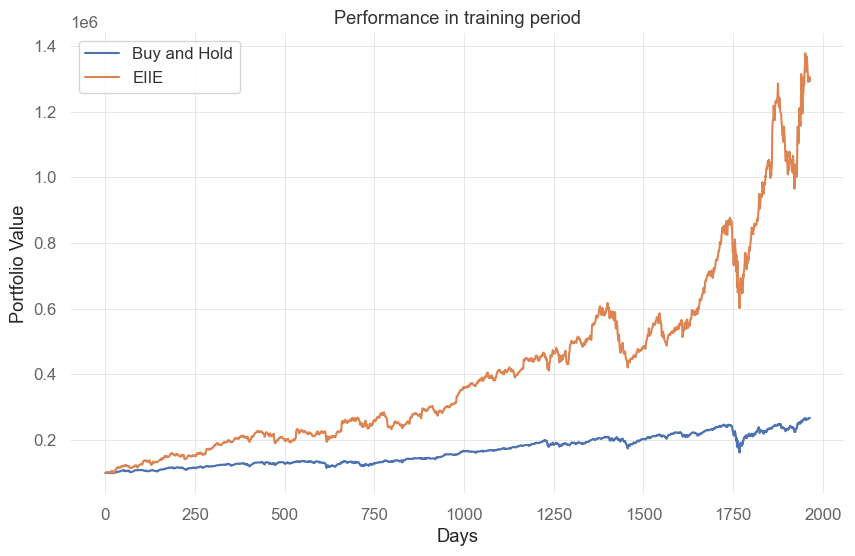

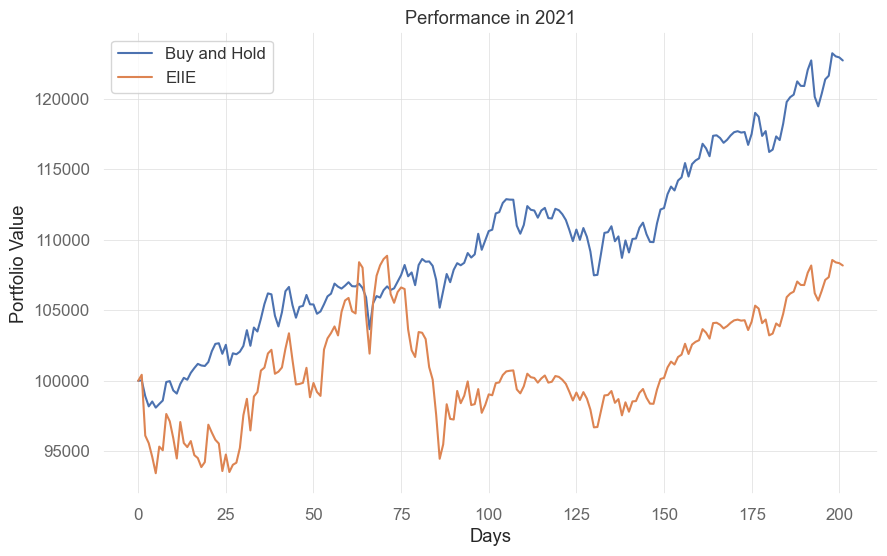

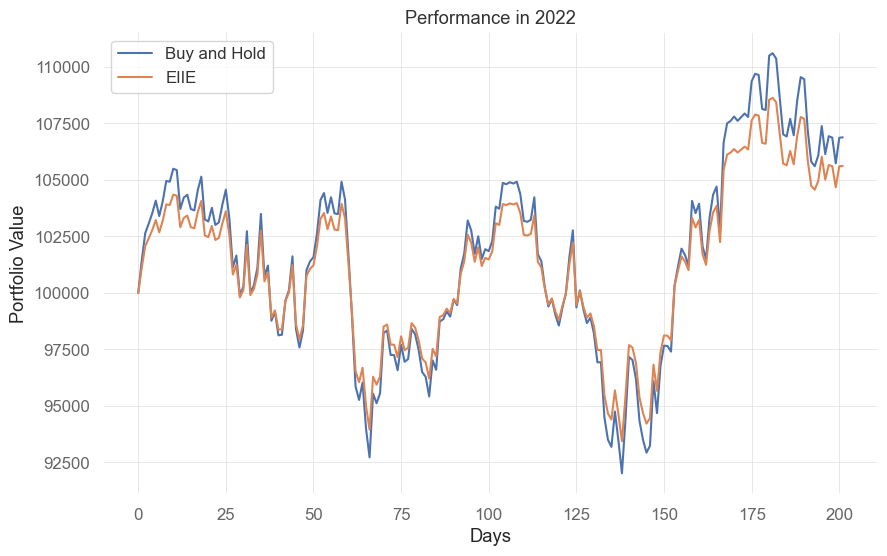

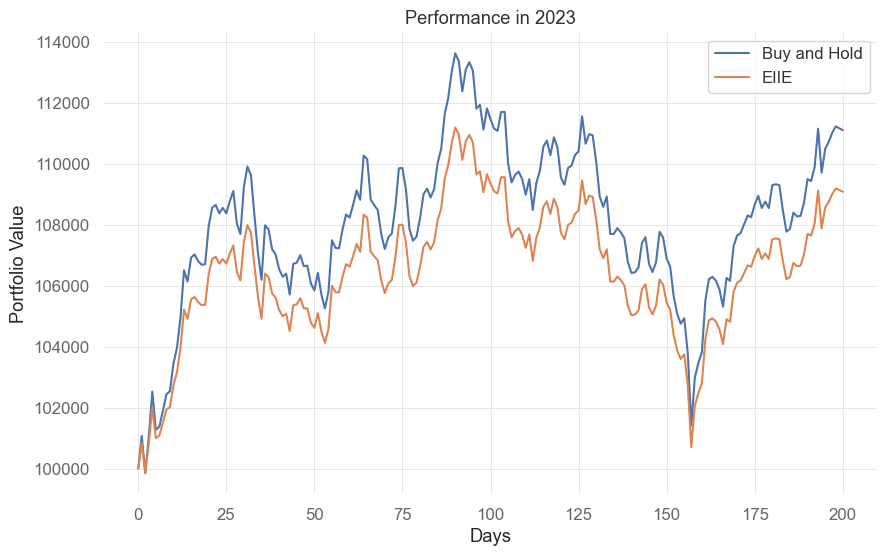

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["train"]["value"], label="EIIE")
#plt.plot(EI3_results["train"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")
#plt.plot(EI3_results["2021"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")
#plt.plot(EI3_results["2022"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

plt.plot(UBAH_results["2023"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2023"]["value"], label="EIIE")
#plt.plot(EI3_results["2023"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2023")
plt.legend()

plt.show()

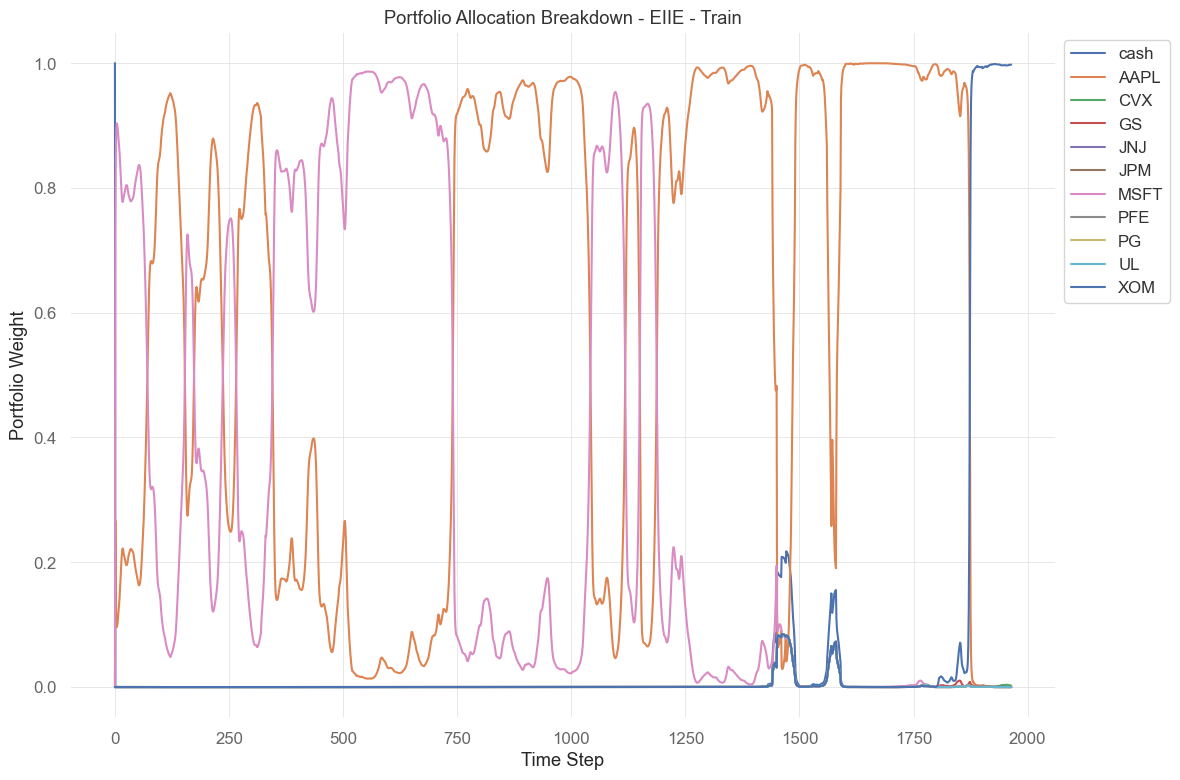

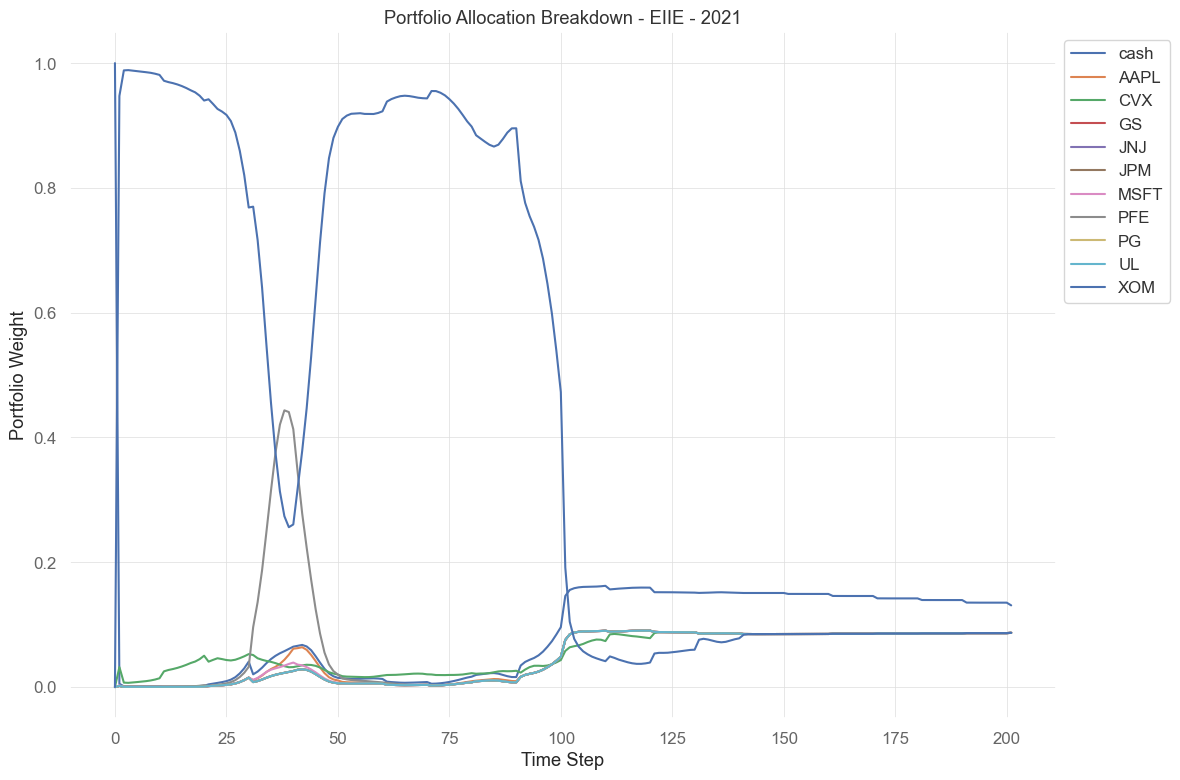

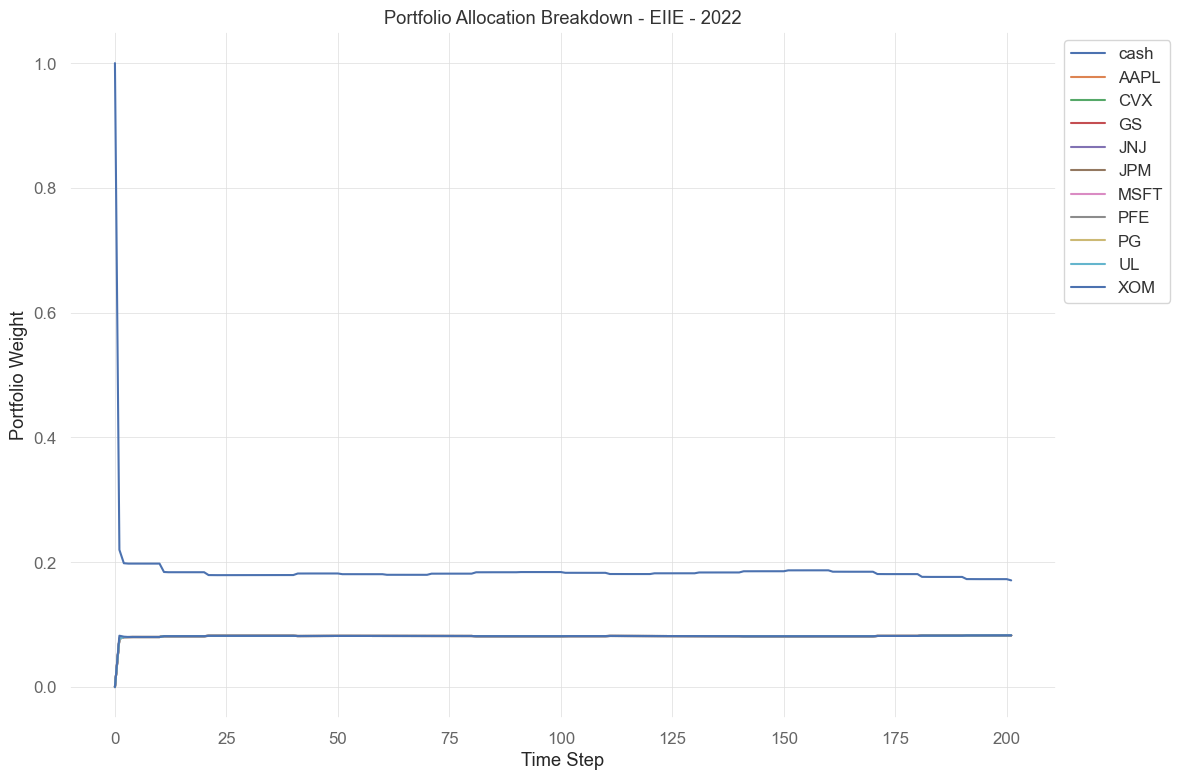

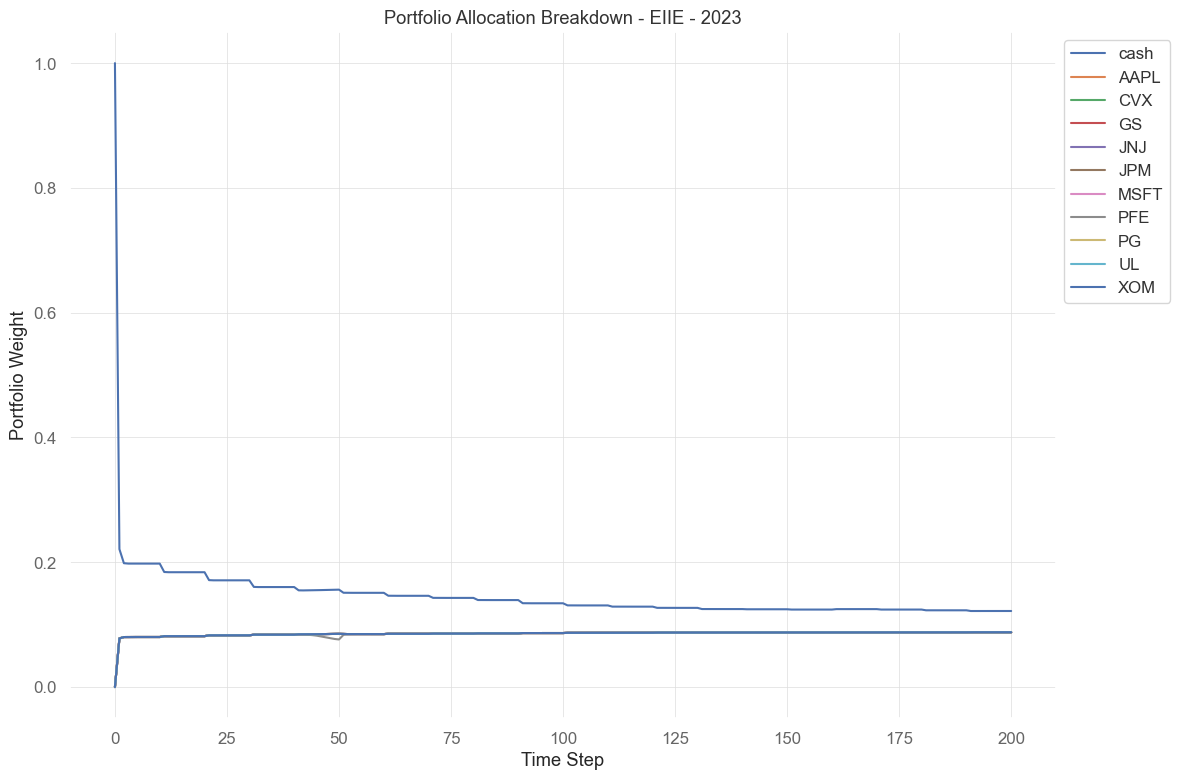

In [76]:
# Function to plot action memory
def plot_action_memory(actions, tickers, label):
    """Visualize portfolio allocation over time."""
    actions_df = pd.DataFrame(actions, columns=["cash"] + tickers)
    actions_df.plot(kind="line", figsize=(12, 8), title=f"Portfolio Allocation Breakdown - {label}")
    plt.ylabel("Portfolio Weight")
    plt.xlabel("Time Step")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot EIIE actions for the training period
plot_action_memory(EIIE_results["train"]["actions"], TEST_SET, "EIIE - Train")

# Plot EIIE actions for 2021
plot_action_memory(EIIE_results["2021"]["actions"], TEST_SET, "EIIE - 2021")

# Plot EIIE actions for 2022
plot_action_memory(EIIE_results["2022"]["actions"], TEST_SET, "EIIE - 2022")

# Plot EIIE actions for 2023
plot_action_memory(EIIE_results["2023"]["actions"], TEST_SET, "EIIE - 2023")

# Similarly, plot UBAH actions for each period
# plot_action_memory(UBAH_results["train"]["actions"], TEST_SET, "UBAH - Train")
# plot_action_memory(UBAH_results["2021"]["actions"], TEST_SET, "UBAH - 2021")
# plot_action_memory(UBAH_results["2022"]["actions"], TEST_SET, "UBAH - 2022")
# plot_action_memory(UBAH_results["2023"]["actions"], TEST_SET, "UBAH - 2023")
